In [1]:
#Importing necessary libraries

from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from textblob import TextBlob


import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from collections import Counter

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\FF0x\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Connecting to the Mongo Database to get the data

client = MongoClient(port=27017)
db = client.trip_advisor
collection = db.reviews_new
df = pd.DataFrame(list(collection.find()))

In [3]:
df.head()

,_id,poi_name,title,date,review_rating,text,date_of_visit,reviewer
0,"{'id': '822488814', 'poi_location_id': '380729...",To Tsai Thessaloniki,"Delicious tea, for tea lovers","December 19, 2021",50,"If you are a tea lover , this is the place to ...",December 2021,"{'name': 'Stefanos B', 'handle': 'stefanosb114..."
1,"{'id': '821022146', 'poi_location_id': '107988...",Koukos,Tasty croissants,"December 4, 2021",50,"The place has incredible decoration, very uniq...",October 2021,"{'name': 'Jimmys', 'handle': 'Poliorkitis96', ..."
2,"{'id': '831588926', 'poi_location_id': '151171...",Judah Club,WOW!,"March 18, 2022",50,Store and cafe - 5/5. Food and food presentati...,March 2022,"{'name': 'Reza S', 'handle': '392rezas', 'cont..."
3,"{'id': '793282537', 'poi_location_id': '380729...",To Tsai Thessaloniki,Awesome place!,"June 20, 2021",50,"The staff was amazing, the tea sublime and the...",June 2021,"{'name': 'Dee', 'handle': 'deesvs', 'location'..."
4,"{'id': '802555010', 'poi_location_id': '107988...",Koukos,Great pastry and sandwich shop,"August 8, 2021",50,Went to this shop out of curiosity and to try ...,August 2021,"{'name': 'Stefan Laurentiu', 'handle': 'stefan..."


In [4]:
# Create subset of users with age group info
age_subset = []

for item in collection.find():
    reviewer = item['reviewer']
    try:
        age_group = reviewer['age']
        age_subset.append(item)
    except:
        None

len(age_subset)

331

In [5]:
# Create subset of users with gender info
gender_subset = []

for item in collection.find():
    reviewer = item['reviewer']
    try:
        gender_group = reviewer['sex']
        gender_subset.append(reviewer)
        
    except:
        None

len(gender_subset)

419

In [6]:
def preprocess(ReviewText):
    ReviewText = ReviewText.str.replace("(<br/>)", "")
    ReviewText = ReviewText.str.replace('(<a).*(>).*(</a>)', '')
    ReviewText = ReviewText.str.replace('(&amp)', '')
    ReviewText = ReviewText.str.replace('(&gt)', '')
    ReviewText = ReviewText.str.replace('(&lt)', '')
    ReviewText = ReviewText.str.replace('(\xa0)', ' ')  
    return ReviewText
df['Review Text'] = preprocess(df['text'])

df['polarity'] = df['Review Text'].map(lambda text: TextBlob(text).sentiment.polarity)

In [7]:
df.head()

,_id,poi_name,title,date,review_rating,text,date_of_visit,reviewer,Review Text,polarity
0,"{'id': '822488814', 'poi_location_id': '380729...",To Tsai Thessaloniki,"Delicious tea, for tea lovers","December 19, 2021",50,"If you are a tea lover , this is the place to ...",December 2021,"{'name': 'Stefanos B', 'handle': 'stefanosb114...","If you are a tea lover , this is the place to ...",0.800000
1,"{'id': '821022146', 'poi_location_id': '107988...",Koukos,Tasty croissants,"December 4, 2021",50,"The place has incredible decoration, very uniq...",October 2021,"{'name': 'Jimmys', 'handle': 'Poliorkitis96', ...","The place has incredible decoration, very uniq...",0.399500
2,"{'id': '831588926', 'poi_location_id': '151171...",Judah Club,WOW!,"March 18, 2022",50,Store and cafe - 5/5. Food and food presentati...,March 2022,"{'name': 'Reza S', 'handle': '392rezas', 'cont...",Store and cafe - 5/5. Food and food presentati...,0.433333
3,"{'id': '793282537', 'poi_location_id': '380729...",To Tsai Thessaloniki,Awesome place!,"June 20, 2021",50,"The staff was amazing, the tea sublime and the...",June 2021,"{'name': 'Dee', 'handle': 'deesvs', 'location'...","The staff was amazing, the tea sublime and the...",0.466667
4,"{'id': '802555010', 'poi_location_id': '107988...",Koukos,Great pastry and sandwich shop,"August 8, 2021",50,Went to this shop out of curiosity and to try ...,August 2021,"{'name': 'Stefan Laurentiu', 'handle': 'stefan...",Went to this shop out of curiosity and to try ...,0.350000


In [8]:
dataf = pd.DataFrame(gender_subset)

dataf = dataf.join(df['text'])
dataf = dataf.join(df['polarity'])
print(dataf.isnull().sum())

name                0
handle              0
location            0
sex                 0
contributions      26
cities_visited     26
age                98
helpful_votes      50
photo             149
distribution       20
text                0
polarity            0
dtype: int64


In [9]:
dataf.head()

,name,handle,location,sex,contributions,cities_visited,age,helpful_votes,photo,distribution,text,polarity
0,Cynthia A,H9795OWcynthiaa,"Varna, Bulgaria",woman,1.0,2.0,NaN,NaN,NaN,NaN,"If you are a tea lover , this is the place to ...",0.800000
1,ClaireMWrangsjo,ClaireMWrangsjo,"Stockholm, Sweden",woman,5.0,141.0,35-49,1.0,1.0,"{'Excellent': 3, 'Very Good': 1, 'Average': 0,...","The place has incredible decoration, very uniq...",0.399500
2,Ken,KenS990,"Stockholm, Sweden",man,61.0,24.0,35-49,42.0,179.0,"{'Excellent': 35, 'Very Good': 20, 'Average': ...",Store and cafe - 5/5. Food and food presentati...,0.433333
3,MyIsla,MyIsla,"Thessaloniki, Greece",woman,87.0,114.0,35-49,56.0,114.0,"{'Excellent': 52, 'Very Good': 18, 'Average': ...","The staff was amazing, the tea sublime and the...",0.466667
4,Dekker51,Dekker51,"THESSALONIKI, GREECE",man,88.0,131.0,25-34,59.0,18.0,"{'Excellent': 22, 'Very Good': 51, 'Average': ...",Went to this shop out of curiosity and to try ...,0.350000


In [10]:
# Dealing with missing values

updated_df = dataf.dropna(subset=['age'])
updated_df = updated_df.reset_index(drop= True)

updated_df['contributions']=updated_df['contributions'].fillna(updated_df['contributions'].mean())
updated_df['contributions'] = updated_df['contributions'].apply(lambda x: round(x))

updated_df['cities_visited']=updated_df['cities_visited'].fillna(updated_df['cities_visited'].mean())
updated_df['cities_visited'] = updated_df['cities_visited'].apply(lambda x: round(x))

updated_df['helpful_votes']=updated_df['helpful_votes'].fillna(updated_df['helpful_votes'].mean())
updated_df['helpful_votes'] = updated_df['helpful_votes'].apply(lambda x: round(x))

updated_df['photo']=updated_df['photo'].fillna(updated_df['photo'].mean())
updated_df['photo'] = updated_df['photo'].apply(lambda x: round(x))

updated_df.dropna(subset=['distribution'], inplace=True)
updated_df = updated_df.reset_index(drop= True)
#updated_df.info()

print(updated_df.isnull().sum())

name              0
handle            0
location          0
sex               0
contributions     0
cities_visited    0
age               0
helpful_votes     0
photo             0
distribution      0
text              0
polarity          0
dtype: int64


In [11]:
# Dealing with Distributions 

from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer()

updated_df['distribution'].head()
vec_df = vec.fit_transform(updated_df['distribution']).toarray()

# creating a list of column names
column_values = vec.get_feature_names()

vec_df = pd.DataFrame(data = vec_df,columns= column_values)

updated_df = updated_df.join(vec_df).drop(columns=['distribution'])

In [12]:
#Add Linguistic features

# Define a list of commonly found punctuations
punctuation = ('!', "," ,"\'" ,";" ,"\"", ".", "-" ,"?")
# Define a list of commonly found emojis
emojis = ('🤣','👍','😭','🙏','😘','🥰','😍','😊','🤩')

updated_df['punc_count'] = updated_df['text'].apply(lambda x : len([a for a in x if a in punctuation]))
updated_df['capitals'] = updated_df['text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
updated_df['num_exclamation_marks'] =updated_df['text'].apply(lambda x: x.count('!'))
updated_df['num_question_marks'] = updated_df['text'].apply(lambda x: x.count('?'))
updated_df['num_punctuation'] = updated_df['text'].apply(lambda x: sum(x.count(w) for w in punctuation))
updated_df['num_emojis'] = updated_df['text'].apply(lambda x: sum(x.count(w) for w in emojis))


In [13]:
#Add feature - Sentiment based on the user's ratings

ratings = ['1','2','3','4','5']

ratings_count = []
for rating in ratings:
    myquery = { "review_rating": { "$regex": f"^{rating}" } }
    count = collection.count_documents(myquery)
    ratings_count.append(count)
    print(rating, ': ', count)

# negative: ratings below 4
# neutral: ratings equal to 4
# positive: ratings equal to 5

neutral_range = {"low": 40, "high": 50}
updated_df["Sentiment"] = "neutral"
updated_df["Sentiment"].loc[df["review_rating"].astype(int) < neutral_range["low"]] = "negative"
updated_df["Sentiment"].loc[df["review_rating"].astype(int) >= neutral_range["high"]] = "positive"
updated_df['Sentiment'].value_counts()


1 :  43
2 :  24
3 :  74
4 :  271
5 :  840


D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


positive    276
neutral      22
negative     11
Name: Sentiment, dtype: int64

In [14]:
# We will use one-hot-encoding to convert categorical data to numerical data
categorical_data_cols = ['age','Sentiment']

onehot_encoder = OneHotEncoder()

onehot_encoder_df = pd.DataFrame(onehot_encoder.fit_transform(updated_df[categorical_data_cols]).toarray())

updated_df = updated_df.join(onehot_encoder_df).drop(columns=categorical_data_cols)
updated_df

,name,handle,location,sex,contributions,cities_visited,helpful_votes,photo,text,polarity,...,num_punctuation,num_emojis,0,1,2,3,4,5,6,7
0,ClaireMWrangsjo,ClaireMWrangsjo,"Stockholm, Sweden",woman,5,141,1,1,"The place has incredible decoration, very uniq...",0.399500,...,12,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,Ken,KenS990,"Stockholm, Sweden",man,61,24,42,179,Store and cafe - 5/5. Food and food presentati...,0.433333,...,10,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,MyIsla,MyIsla,"Thessaloniki, Greece",woman,87,114,56,114,"The staff was amazing, the tea sublime and the...",0.466667,...,4,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,Dekker51,Dekker51,"THESSALONIKI, GREECE",man,88,131,59,18,Went to this shop out of curiosity and to try ...,0.350000,...,3,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,enterjim,enterjim,"Thessaloniki, Greece",man,24,52,5,5,"Amazing food, sun is up was delicious and the ...",0.512500,...,2,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,daw75,daw75,"Berlin, Germany",man,63,111,39,11,The decoration was fantastic and the view outs...,0.390741,...,5,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
305,Carol A S,carolas936,"Marietta, Georgia",woman,157,125,82,123,They serve the best coffee I have tried in thi...,0.775000,...,2,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
306,Panagiotis Hatziioannou,P_Hatz98,"Thessaloniki, Greece",man,9,2,1,2,We went there a Saturday noon and we had coffe...,0.408333,...,6,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
307,Evita S,evitaS_12,"Thessaloniki, Greece",woman,905,204,82,123,"Nice juice bar, large selection of fruits, smo...",0.387857,...,8,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [15]:
#X = updated_df.drop(['sex','name','handle','location','text','contributions','cities_visited','helpful_votes','photo'], axis = 1)
X = updated_df.drop(['sex','name','handle','location','text'], axis = 1)
y = updated_df['sex']

In [16]:
X = StandardScaler().fit_transform(X)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Prepare cross-validation (cv)
cv = KFold(n_splits = 5, random_state = None)

# Performance
p_score = lambda model, score: print('Performance of the %s model is %0.2f%%' % (model, score * 100))

# Classifiers
names = [
    "Logistic Regression", "Logistic Regression with Polynomial Hypotheses",
    "Linear SVM", "RBF SVM", "Neural Net", "Decision Tree","Random Forest"
    ]

classifiers = [
    LogisticRegression(solver='lbfgs', max_iter=1000),
    make_pipeline(PolynomialFeatures(3), LogisticRegression(solver='lbfgs', max_iter=1000)),
    SVC(kernel="linear", C=0.025,max_iter=1000 ),
    SVC(gamma=2, C=1,max_iter=1000),
    MLPClassifier(alpha=1,max_iter=1000),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=100)
]

In [19]:
# iterate over classifiers
models = []
trained_classifiers = []
for name, clf in zip(names, classifiers):
    scores = []
    for train_indices, test_indices in cv.split(X):
        clf.fit(X[train_indices], y[train_indices].ravel())
        scores.append( clf.score(X_test, y_test.ravel()) )
    
    min_score = min(scores)
    max_score = max(scores)
    avg_score = sum(scores) / len(scores)
    
    trained_classifiers.append(clf)
    models.append((name, min_score, max_score, avg_score))
    
fin_models = pd.DataFrame(models, columns = ['Name', 'Min Score', 'Max Score', 'Mean Score'])

In [20]:
#So our experimental research says that the Random Forest performs the best
fin_models.sort_values(['Mean Score'])

,Name,Min Score,Max Score,Mean Score
2,Linear SVM,0.516129,0.548387,0.532258
0,Logistic Regression,0.532258,0.612903,0.567742
4,Neural Net,0.709677,0.790323,0.758065
1,Logistic Regression with Polynomial Hypotheses,0.838710,0.919355,0.887097
3,RBF SVM,0.838710,0.951613,0.906452
5,Decision Tree,0.887097,0.967742,0.929032
6,Random Forest,0.919355,0.983871,0.945161


# Question 1 - Calculate the percentage of each class (e.g., male vs. female or age groups) in your training data users and in the whole dataset (after you use your model for prediction)

In [21]:
# Percentage of each class in the training data users
y_train.value_counts(normalize=True) 

man      0.554656
woman    0.445344
Name: sex, dtype: float64

In [42]:
# Create Random Forest classifer object
test_clf = RandomForestClassifier(n_estimators=1000) 

#Fit/Train the model using the training sets
test_clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = test_clf.predict(X_test)


In [43]:
# Percentage of each class in the dataset after model prediction
y_pred = pd.DataFrame(data = y_pred)

#y_pred
y_pred[0].value_counts(normalize=True)

man      0.564516
woman    0.435484
Name: 0, dtype: float64

# Question 2 - Visualize the most common words per class (e.g., male vs. female or age groups) and sentiment/polarity (negative vs. positive) in a bar chart or word cloud.


In [24]:
woman_info = []
man_info = []
for item in collection.find():
    reviewer = item['reviewer']
    try:
        sex = reviewer['sex']
        if sex == 'woman':
            woman_info.append(item)
        elif sex == 'man':
            man_info.append(item)    
    except:
        None

woman_df = pd.DataFrame(data = woman_info)
man_df = pd.DataFrame(data = man_info)

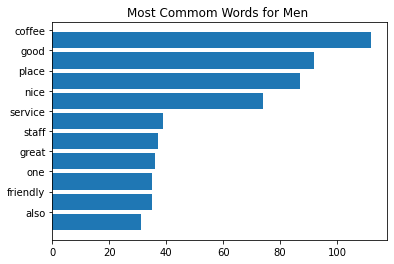

In [25]:
#Most common words - Men

topic_words = [ z.lower() for y in
                   [ x.split() for x in man_df['text'] if isinstance(x, str)]
                   for z in y]
word_count_dict = dict(Counter(topic_words))
popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
plt.barh(range(10), [word_count_dict[w] for w in reversed(popular_words_nonstop[0:10])])
plt.yticks([x + 0.5 for x in range(10)], reversed(popular_words_nonstop[0:10]))
plt.title("Most Commom Words for Men ")
plt.show()

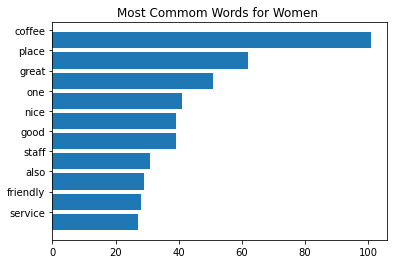

In [26]:
#Most common words - Women

topic_words = [ z.lower() for y in
                   [ x.split() for x in woman_df['text'] if isinstance(x, str)]
                   for z in y]
word_count_dict = dict(Counter(topic_words))
popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
plt.barh(range(10), [word_count_dict[w] for w in reversed(popular_words_nonstop[0:10])])
plt.yticks([x + 0.5 for x in range(10)], reversed(popular_words_nonstop[0:10]))
plt.title("Most Commom Words for Women ")
plt.show()

In [27]:
positive = []
negative = []

list = updated_df.values.tolist()

for item in list:
    #print(item)
    polarity = item[9]
    if polarity > 0: 
        positive.append(item)
    else : 
        negative.append(item)
    
positive_df = pd.DataFrame(data = positive)
negative_df = pd.DataFrame(data = negative)

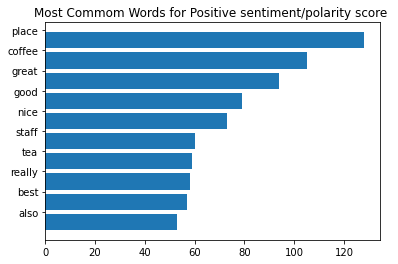

In [28]:
#Most common words - Positive Polarity/ sentiment score

topic_words = [ z.lower() for y in
                   [ x.split() for x in positive_df[8] if isinstance(x, str)]
                   for z in y]
word_count_dict = dict(Counter(topic_words))
popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
plt.barh(range(10), [word_count_dict[w] for w in reversed(popular_words_nonstop[0:10])])
plt.yticks([x + 0.5 for x in range(10)], reversed(popular_words_nonstop[0:10]))
plt.title("Most Commom Words for Positive sentiment/polarity score ")
plt.show()

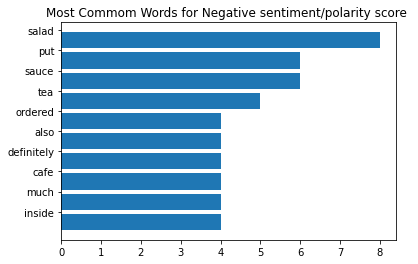

In [29]:
#Most common words - Negative Polarity/ sentiment score

topic_words = [ z.lower() for y in
                   [ x.split() for x in negative_df[8] if isinstance(x, str)]
                   for z in y]
word_count_dict = dict(Counter(topic_words))
popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
plt.barh(range(10), [word_count_dict[w] for w in reversed(popular_words_nonstop[0:10])])
plt.yticks([x + 0.5 for x in range(10)], reversed(popular_words_nonstop[0:10]))
plt.title("Most Commom Words for Negative sentiment/polarity score ")
plt.show()

# Question 3 - Create a box plot of user ratings visualizing the differences in ratings between user classes. Also, create a similar box plot for sentiment/polarity scores.


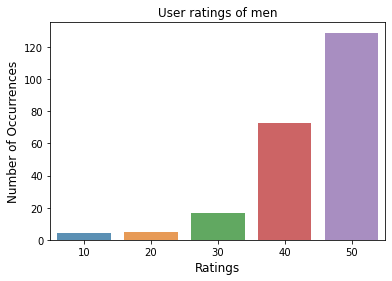

In [30]:
# User ratings for men
man2 = man_df['review_rating'].value_counts()

import seaborn as sns

plt.figure()
sns.barplot(man2.index, man2.values, alpha=0.8)
plt.title('User ratings of men')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Ratings', fontsize=12)
plt.show()

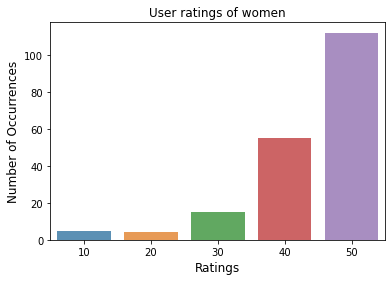

In [31]:
# User ratings for women
woman2 = woman_df['review_rating'].value_counts()

sns.barplot(woman2.index, woman2.values, alpha=0.8)
plt.title('User ratings of women')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Ratings', fontsize=12)
plt.show()


In [32]:
# User ratings for each polarity 

y1 = df.loc[df['review_rating'] == '10']['polarity']
y2 = df.loc[df['review_rating'] == '20']['polarity']
y3 = df.loc[df['review_rating'] == '30']['polarity']
y4 = df.loc[df['review_rating'] == '40']['polarity']
y5 = df.loc[df['review_rating'] == '50']['polarity']

In [33]:
import plotly
import plotly.graph_objs as go

trace1 = go.Box(
    y=y1,
    name = 'Rating 1-star',
    marker = dict(
        color = 'rgb(0, 128, 128)',
    )
)
trace2 = go.Box(
    y=y2,
    name = 'Rating 2-star',
    marker = dict(
        color = 'rgb(10, 140, 208)',
    )
)
trace3 = go.Box(
    y=y3,
    name = 'Rating 3-star',
    marker = dict(
        color = 'rgb(12, 102, 14)',
    )
)
trace4 = go.Box(
    y=y4,
    name = 'Rating 4-star',
    marker = dict(
        color = 'rgb(10, 0, 100)',
    )
)
trace5 = go.Box(
    y=y5,
    name = 'Rating 5-star',
    marker = dict(
        color = 'rgb(100, 0, 10)',
    )
)
data = [trace1, trace2, trace3, trace4, trace5]
layout = go.Layout(
    title = "Sentiment Polarity Boxplot of User Ratings"
)

fig = go.Figure(data=data,layout=layout)
plotly.offline.iplot(fig, filename = "Sentiment Polarity Boxplot of User Ratings")